In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Load parquet file handle (no data in memory)
parquet_file = pq.ParquetFile('climate_data_from_1982.parquet')

# Load first row group as sample
sample = parquet_file.read_row_group(0).to_pandas()

print("Libraries loaded.")
print(f"Total rows in file: {parquet_file.metadata.num_rows:,}")
print(f"Sample shape: {sample.shape}")
sample.head()

Libraries loaded.
Total rows in file: 13,540,116
Sample shape: (1048576, 7)


,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,276.292267
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,275.092407
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,276.418518
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,278.893372
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,278.887207


In [3]:
print(f"Sample shape: {sample.shape}\n")

for col in ['scenario', 'nom_dep', 'code_dep', 'metric']:
    print(f"--- {col} ---")
    print(f"Unique values: {sample[col].nunique()}")
    print(sample[col].value_counts())
    print()

Sample shape: (1048576, 7)

--- scenario ---
Unique values: 1
scenario
historical    1048576
Name: count, dtype: int64

--- nom_dep ---
Unique values: 87
nom_dep
Ain                        12053
Aisne                      12053
Allier                     12053
Alpes_Maritimes            12053
Alpes_de_Haute_Provence    12053
                           ...  
Var                        12053
Vaucluse                   12053
Vendee                     12053
Vienne                     12053
Vosges                     12018
Name: count, Length: 87, dtype: int64

--- code_dep ---
Unique values: 87
code_dep
01    12053
02    12053
03    12053
06    12053
04    12053
      ...  
83    12053
84    12053
85    12053
86    12053
88    12018
Name: count, Length: 87, dtype: int64

--- metric ---
Unique values: 1
metric
near_surface_air_temperature    1048576
Name: count, dtype: int64



In [4]:
scenarios = set()
departments = set()
metrics = set()
years = set()
total_nulls = 0

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i, columns=['scenario', 'nom_dep', 'code_dep', 'metric', 'year', 'value']).to_pandas()
    scenarios.update(chunk['scenario'].dropna().unique())
    departments.update(chunk['nom_dep'].dropna().unique())
    metrics.update(chunk['metric'].dropna().unique())
    years.update(chunk['year'].dropna().unique())
    total_nulls += chunk['value'].isnull().sum()
    print(f"Row group {i} done")

print(f"\n{'='*50}")
print(f"Scenarios ({len(scenarios)}):   {sorted(scenarios)}")
print(f"Departments ({len(departments)}): {sorted(departments)[:10]} ...")
print(f"Metrics ({len(metrics)}):     {sorted(metrics)}")
print(f"Years ({len(years)}):       {sorted(years)[0]} — {sorted(years)[-1]}")
print(f"Total null values:  {total_nulls:,}")

Row group 0 done
Row group 1 done
Row group 2 done
Row group 3 done
Row group 4 done
Row group 5 done
Row group 6 done
Row group 7 done
Row group 8 done
Row group 9 done
Row group 10 done
Row group 11 done
Row group 12 done

Scenarios (4):   ['historical', 'ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']
Departments (89): ['Ain', 'Aisne', 'Allier', 'Alpes_Maritimes', 'Alpes_de_Haute_Provence', 'Ardeche', 'Ardennes', 'Ariege', 'Aube', 'Aude'] ...
Metrics (3):     ['daily_maximum_near_surface_air_temperature', 'near_surface_air_temperature', 'precipitation']
Years (69):       1982 — 2050
Total null values:  0


In [5]:
stats_per_metric = defaultdict(lambda: {'count': 0, 'sum': 0, 'min': float('inf'), 'max': float('-inf')})

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i, columns=['metric', 'value']).to_pandas()
    for metric_name, group in chunk.groupby('metric'):
        vals = group['value'].dropna()
        stats_per_metric[metric_name]['count'] += len(vals)
        stats_per_metric[metric_name]['sum'] += vals.sum()
        stats_per_metric[metric_name]['min'] = min(stats_per_metric[metric_name]['min'], vals.min())
        stats_per_metric[metric_name]['max'] = max(stats_per_metric[metric_name]['max'], vals.max())
    print(f"Row group {i} done")

summary = []
for m, s in stats_per_metric.items():
    summary.append({
        'metric': m,
        'count': s['count'],
        'mean': s['sum'] / s['count'] if s['count'] > 0 else None,
        'min': s['min'],
        'max': s['max']
    })

stats_df = pd.DataFrame(summary).sort_values('metric')
stats_df


Row group 0 done
Row group 1 done
Row group 2 done
Row group 3 done
Row group 4 done
Row group 5 done
Row group 6 done
Row group 7 done
Row group 8 done
Row group 9 done
Row group 10 done
Row group 11 done
Row group 12 done


,metric,count,mean,min,max
1,daily_maximum_near_surface_air_temperature,4478308,288.603333,2.532118e+02,319.311035
0,near_surface_air_temperature,4583500,283.964661,2.455779e+02,307.876160
2,precipitation,4478308,0.000085,-2.681981e-23,0.005103


In [6]:
yearly_agg = {}

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i, columns=['scenario', 'year', 'metric', 'value']).to_pandas()
    grouped = chunk.groupby(['scenario', 'year', 'metric'])['value'].agg(['sum', 'count'])
    
    for idx, row in grouped.iterrows():
        key = idx
        if key not in yearly_agg:
            yearly_agg[key] = {'sum': 0, 'count': 0}
        yearly_agg[key]['sum'] += row['sum']
        yearly_agg[key]['count'] += row['count']
    print(f"Row group {i} done")

records = []
for (scenario, year, metric), v in yearly_agg.items():
    records.append({
        'scenario': scenario,
        'year': year,
        'metric': metric,
        'mean_value': v['sum'] / v['count'] if v['count'] > 0 else None,
        'count': v['count']
    })

df_yearly = pd.DataFrame(records).sort_values(['metric', 'scenario', 'year'])
print(f"Yearly aggregation shape: {df_yearly.shape}")
df_yearly.head(10)

Row group 0 done
Row group 1 done
Row group 2 done
Row group 3 done
Row group 4 done
Row group 5 done
Row group 6 done
Row group 7 done
Row group 8 done
Row group 9 done
Row group 10 done
Row group 11 done
Row group 12 done
Yearly aggregation shape: (423, 5)


,scenario,year,metric,mean_value,count
33,historical,1982,daily_maximum_near_surface_air_temperature,287.759854,32485.0
34,historical,1983,daily_maximum_near_surface_air_temperature,286.477664,32485.0
35,historical,1984,daily_maximum_near_surface_air_temperature,286.847960,32574.0
36,historical,1985,daily_maximum_near_surface_air_temperature,286.611551,32485.0
37,historical,1986,daily_maximum_near_surface_air_temperature,287.287713,32485.0
38,historical,1987,daily_maximum_near_surface_air_temperature,286.709744,32485.0
39,historical,1988,daily_maximum_near_surface_air_temperature,287.747553,32574.0
40,historical,1989,daily_maximum_near_surface_air_temperature,286.255169,32485.0
41,historical,1990,daily_maximum_near_surface_air_temperature,287.592538,32485.0
42,historical,1991,daily_maximum_near_surface_air_temperature,287.158316,32485.0


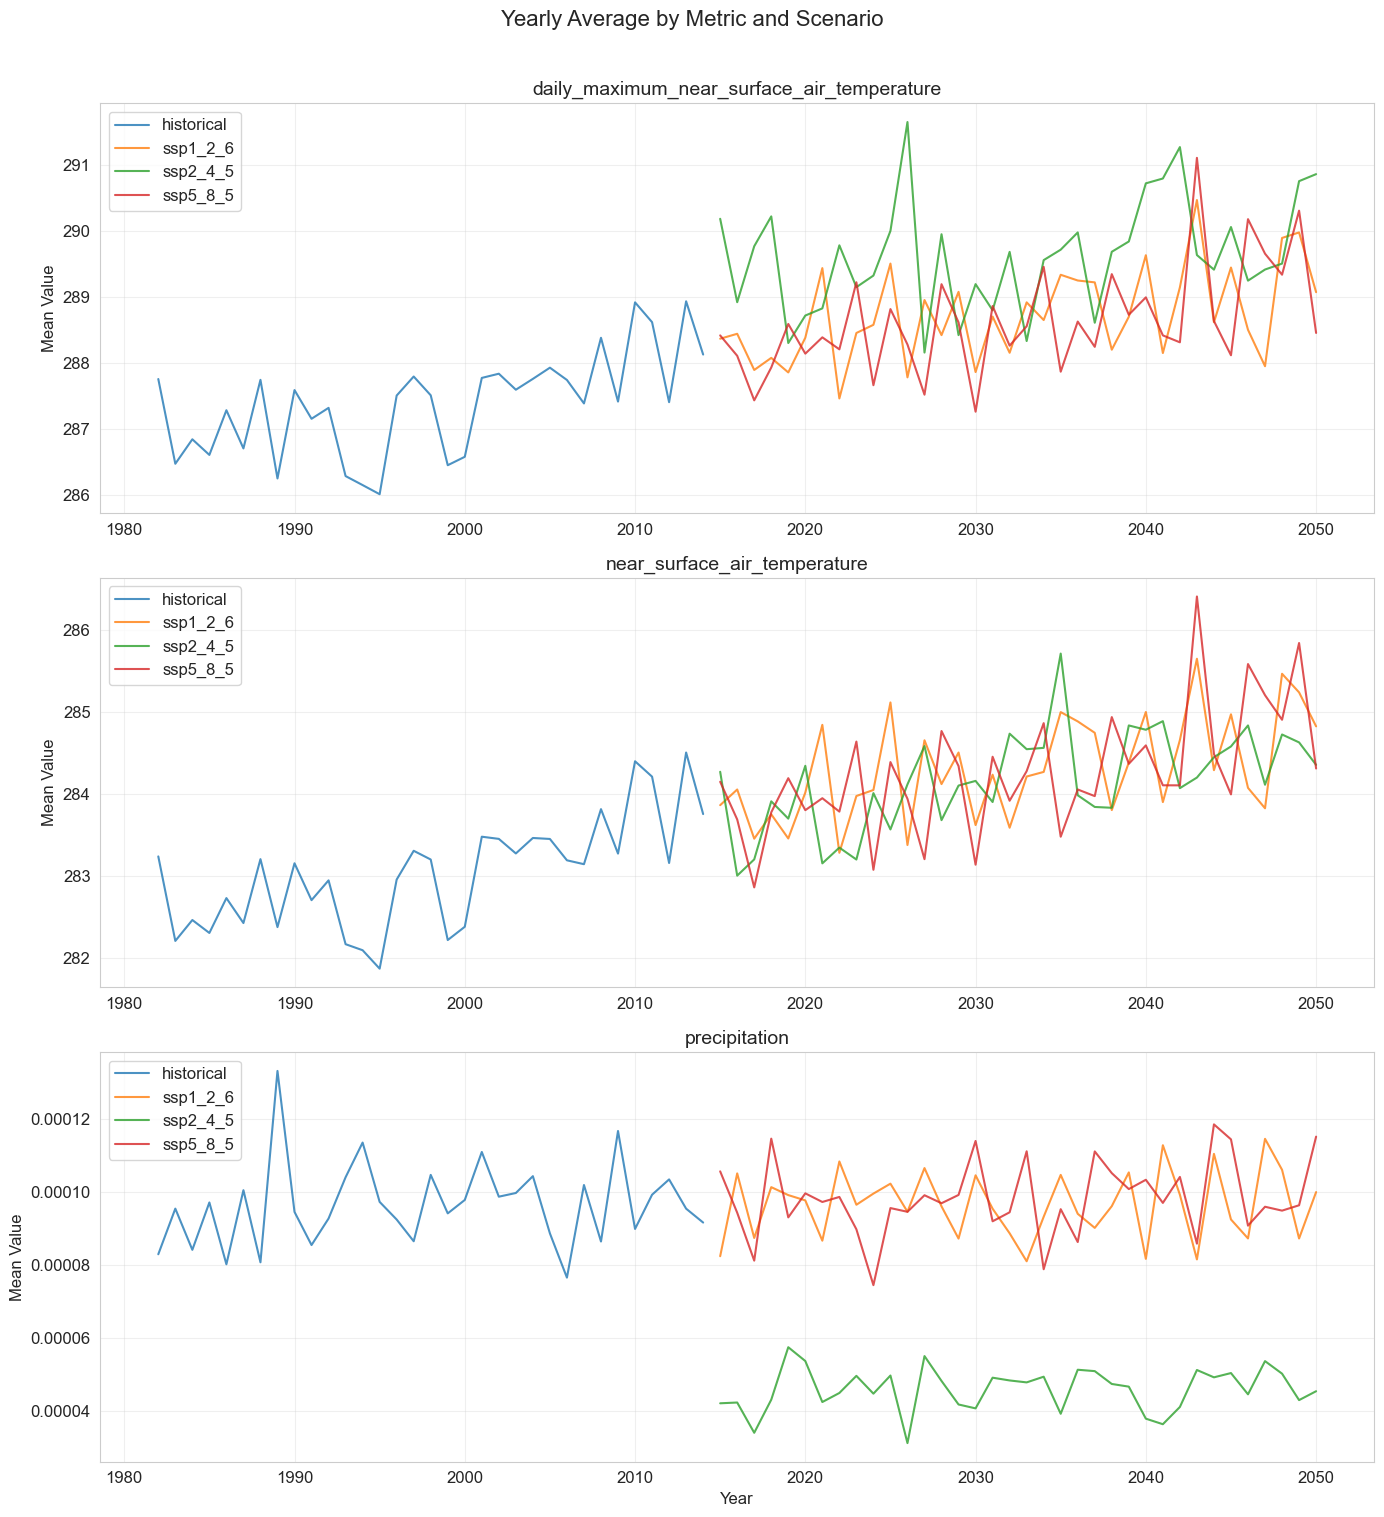

In [7]:
metric_list = df_yearly['metric'].unique()

fig, axes = plt.subplots(len(metric_list), 1, figsize=(14, 5 * len(metric_list)), sharex=False)
if len(metric_list) == 1:
    axes = [axes]

for i, metric_name in enumerate(metric_list):
    subset = df_yearly[df_yearly['metric'] == metric_name]
    for scenario_name, grp in subset.groupby('scenario'):
        grp_sorted = grp.sort_values('year')
        axes[i].plot(grp_sorted['year'], grp_sorted['mean_value'], label=scenario_name, alpha=0.8)
    axes[i].set_title(f'{metric_name}', fontsize=14)
    axes[i].set_ylabel('Mean Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Year')
plt.suptitle('Yearly Average by Metric and Scenario', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


In [8]:
dept_agg = {}

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i, columns=['scenario', 'nom_dep', 'metric', 'value']).to_pandas()
    grouped = chunk.groupby(['scenario', 'nom_dep', 'metric'])['value'].agg(['sum', 'count'])
    
    for idx, row in grouped.iterrows():
        key = idx
        if key not in dept_agg:
            dept_agg[key] = {'sum': 0, 'count': 0}
        dept_agg[key]['sum'] += row['sum']
        dept_agg[key]['count'] += row['count']
    print(f"Row group {i} done")

records = []
for (scenario, dep, metric), v in dept_agg.items():
    records.append({
        'scenario': scenario,
        'nom_dep': dep,
        'metric': metric,
        'mean_value': v['sum'] / v['count'] if v['count'] > 0 else None
    })

df_dept = pd.DataFrame(records)
print(f"Department aggregation shape: {df_dept.shape}")
df_dept.head()

Row group 0 done
Row group 1 done
Row group 2 done
Row group 3 done
Row group 4 done
Row group 5 done
Row group 6 done
Row group 7 done
Row group 8 done
Row group 9 done
Row group 10 done
Row group 11 done
Row group 12 done
Department aggregation shape: (1052, 4)


,scenario,nom_dep,metric,mean_value
0,historical,Ain,near_surface_air_temperature,282.613457
1,historical,Aisne,near_surface_air_temperature,283.034120
2,historical,Allier,near_surface_air_temperature,283.054675
3,historical,Alpes_Maritimes,near_surface_air_temperature,279.528478
4,historical,Alpes_de_Haute_Provence,near_surface_air_temperature,278.288020


In [10]:
for metric_name in df_dept['metric'].unique():
    subset = df_dept[(df_dept['metric'] == metric_name) & (df_dept['scenario'] == 'historical')]
    subset = subset.sort_values('mean_value', ascending=False)
    
    print(f"\n{'='*50}")
    print(f"Metric: {metric_name}")
    print(f"{'='*50}")
    print("TOP 5 departments:")
    print(subset[['nom_dep', 'mean_value']].head().to_string(index=False))
    print("\nBOTTOM 5 departments:")
    print(subset[['nom_dep', 'mean_value']].tail().to_string(index=False))


Metric: near_surface_air_temperature
TOP 5 departments:
          nom_dep  mean_value
 Bouches_du_Rhone  286.622708
           Landes  286.332469
          Gironde  286.305111
Charente_Maritime  285.850431
   Lot_et_Garonne  285.790675

BOTTOM 5 departments:
                nom_dep  mean_value
                 Ariege  279.356405
           Haute_Savoie  279.012321
Alpes_de_Haute_Provence  278.288020
                 Savoie  275.894798
           Hautes_Alpes  273.752572

Metric: daily_maximum_near_surface_air_temperature
TOP 5 departments:
         nom_dep  mean_value
Bouches_du_Rhone  291.458537
          Landes  290.832324
  Lot_et_Garonne  290.720360
            Gers  290.583444
         Gironde  290.387393

BOTTOM 5 departments:
                nom_dep  mean_value
                 Ariege  283.743134
           Haute_Savoie  283.383058
Alpes_de_Haute_Provence  283.151892
                 Savoie  280.434477
           Hautes_Alpes  278.362254

Metric: precipitation
TOP 5 departments

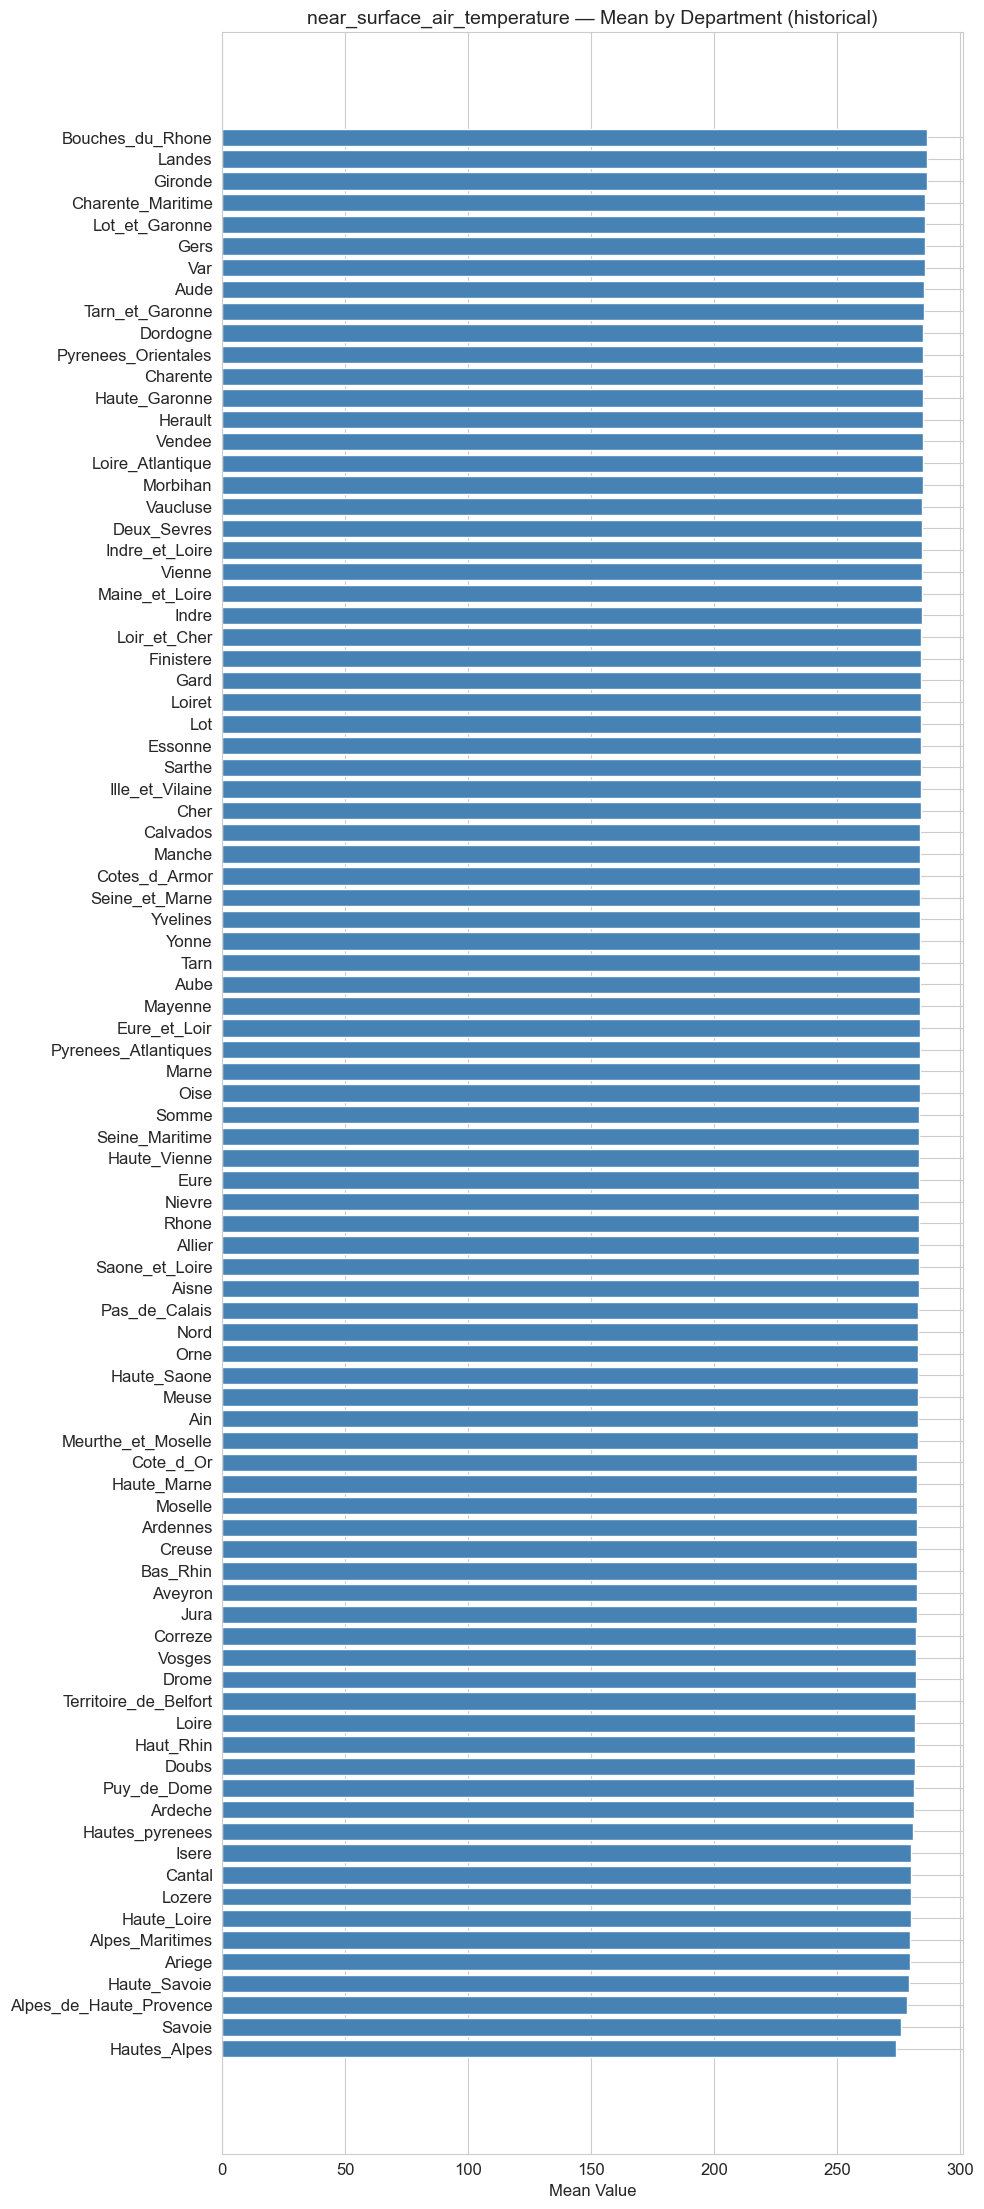

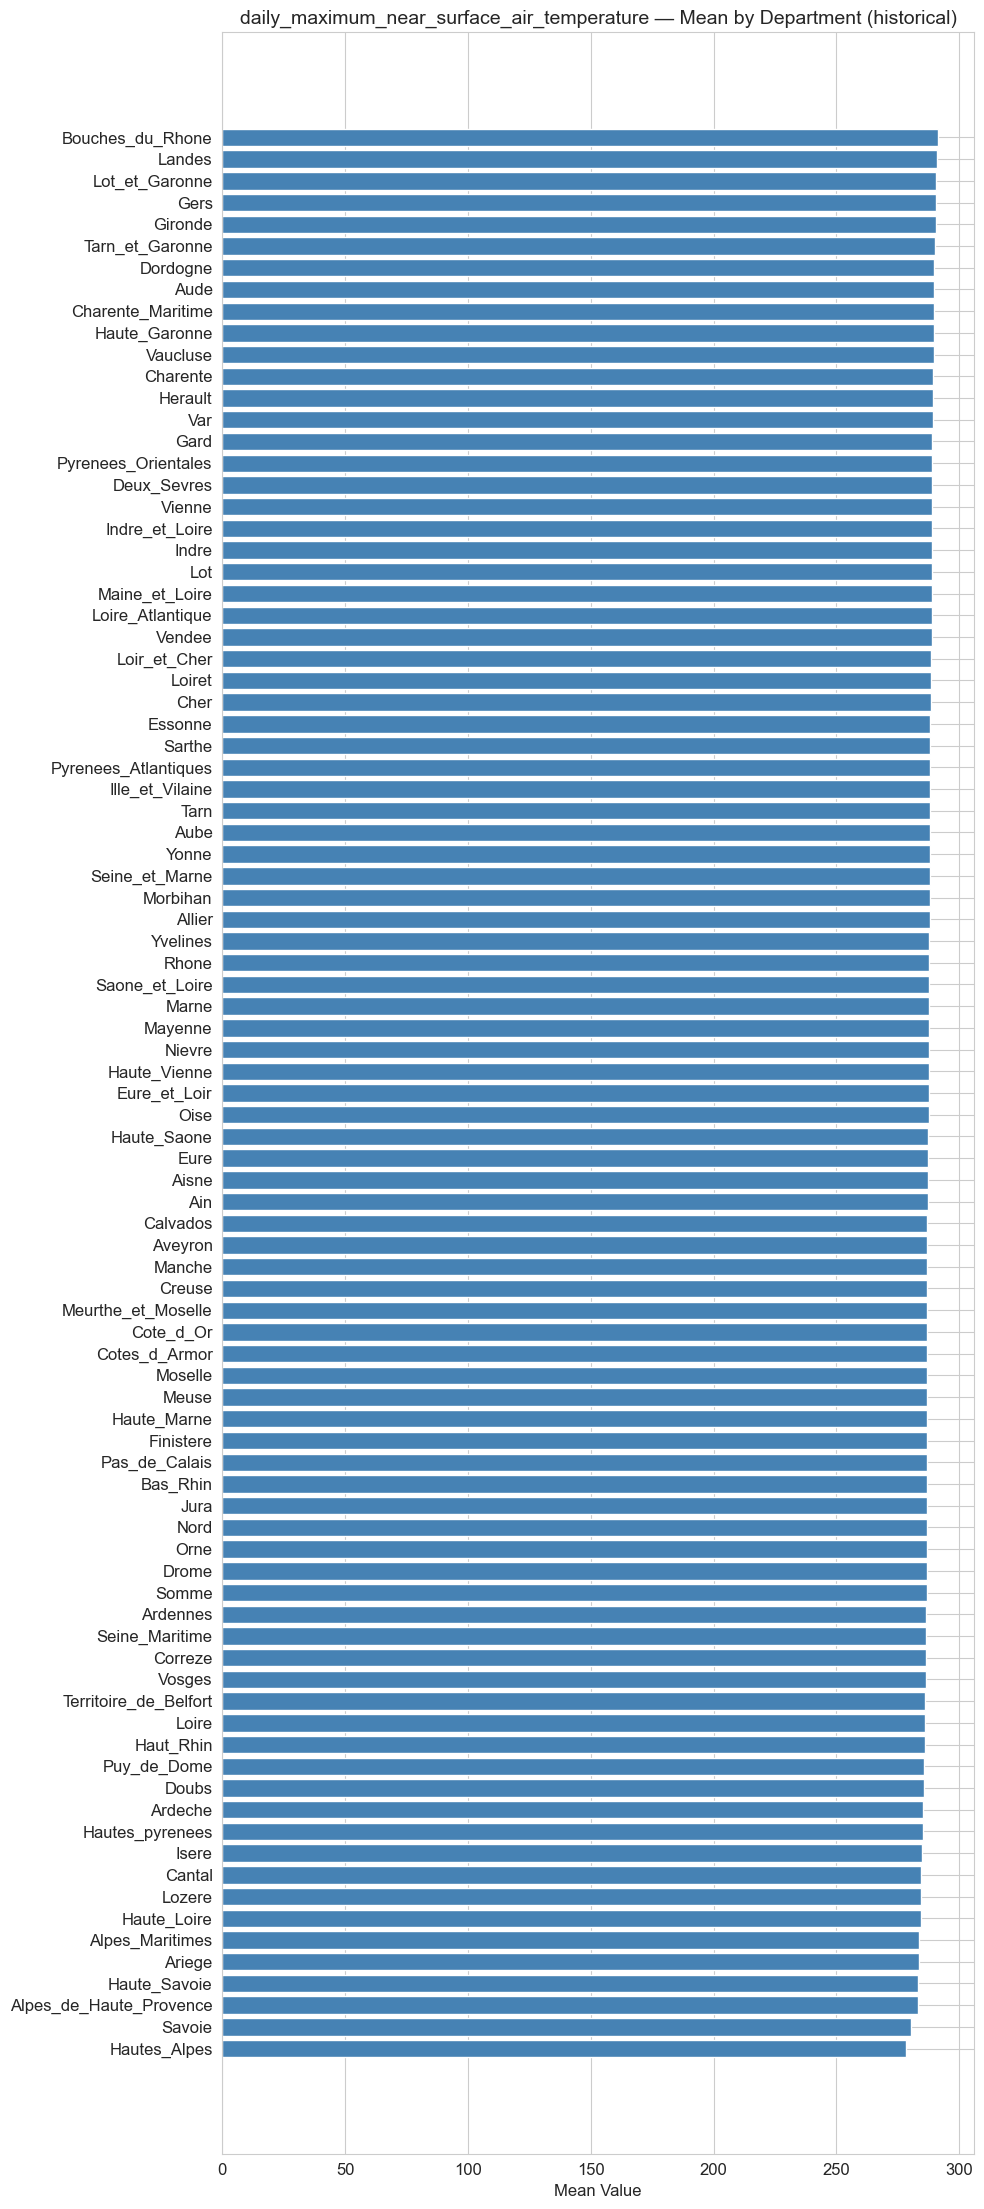

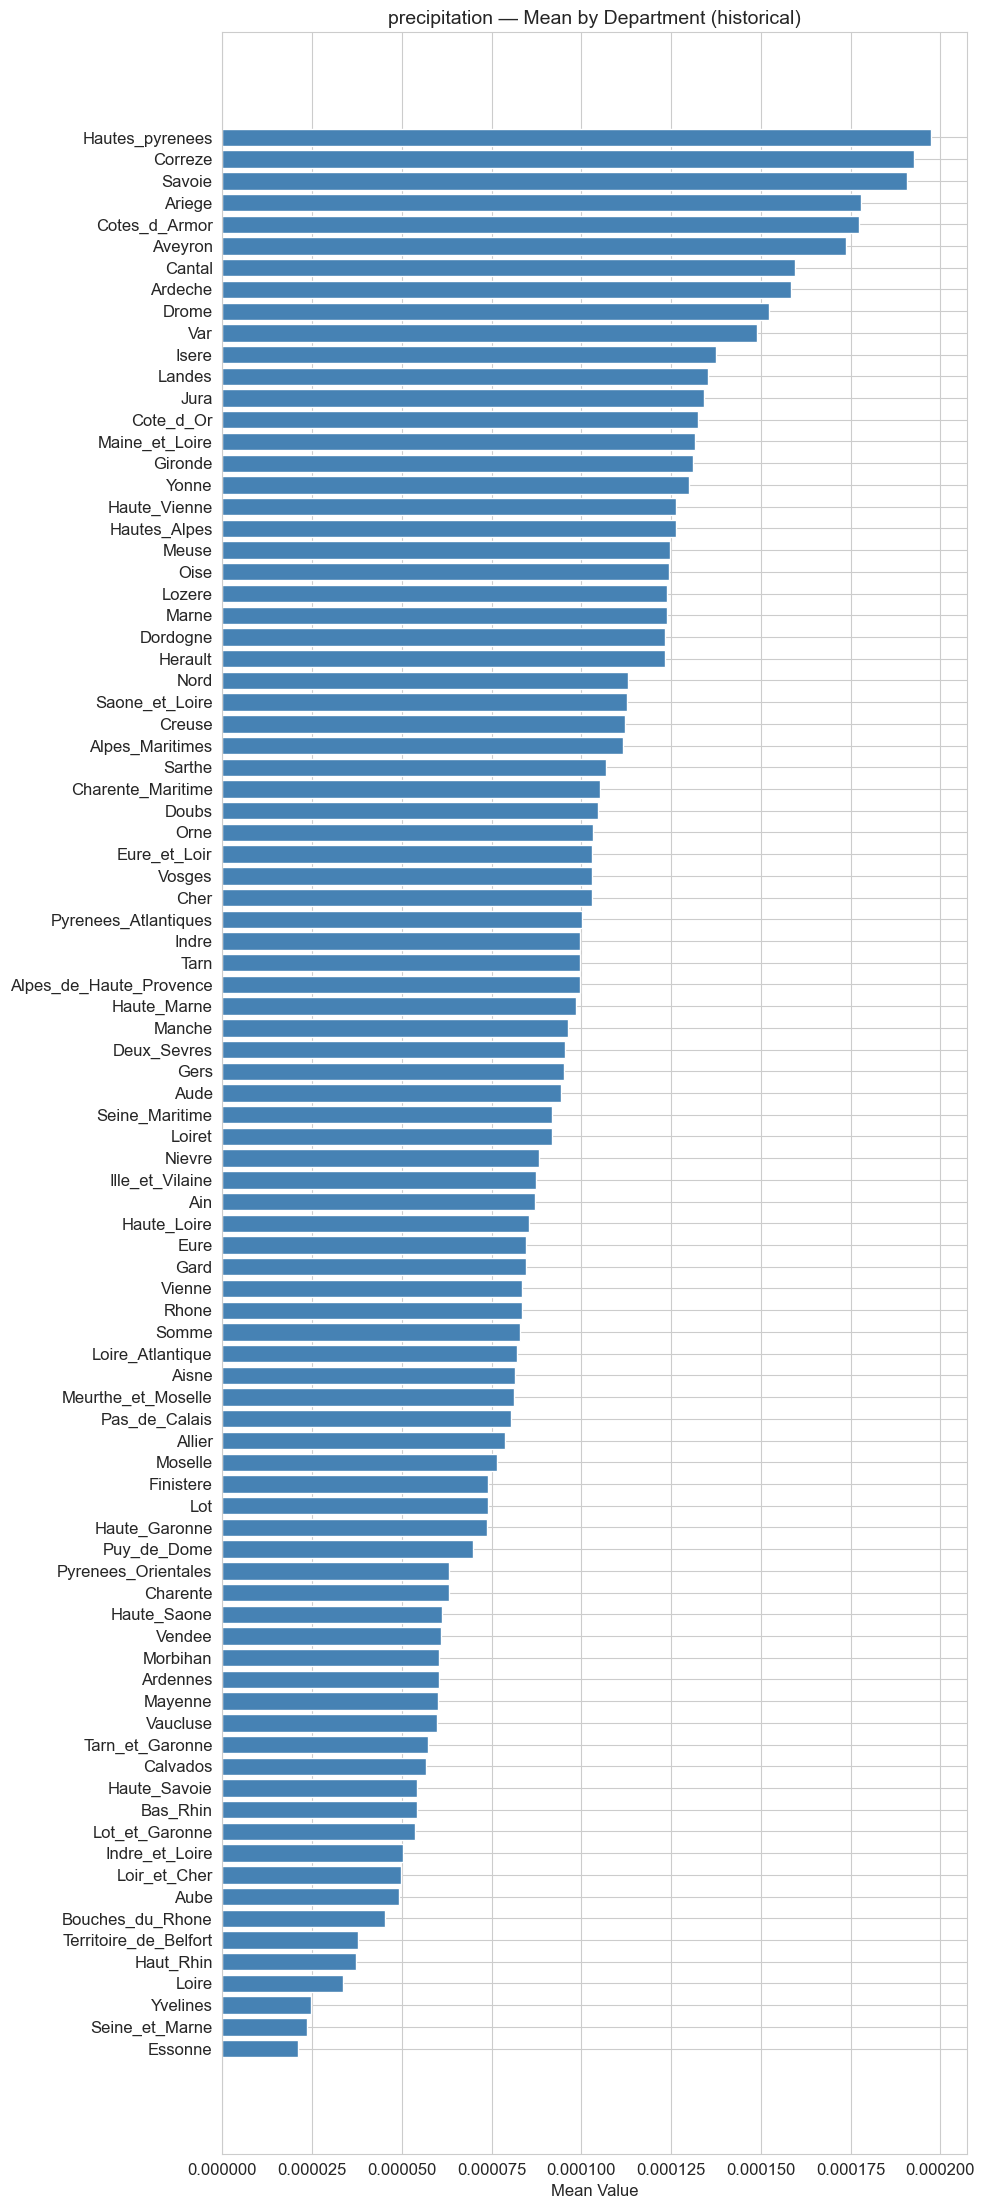

In [11]:
for metric_name in df_dept['metric'].unique():
    subset = df_dept[(df_dept['metric'] == metric_name) & (df_dept['scenario'] == 'historical')]
    subset = subset.sort_values('mean_value', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(subset) * 0.25)))
    ax.barh(subset['nom_dep'], subset['mean_value'], color='steelblue', edgecolor='white')
    ax.set_title(f'{metric_name} — Mean by Department (historical)', fontsize=14)
    ax.set_xlabel('Mean Value')
    plt.tight_layout()
    plt.show()

Sample size for distributions: 150,000


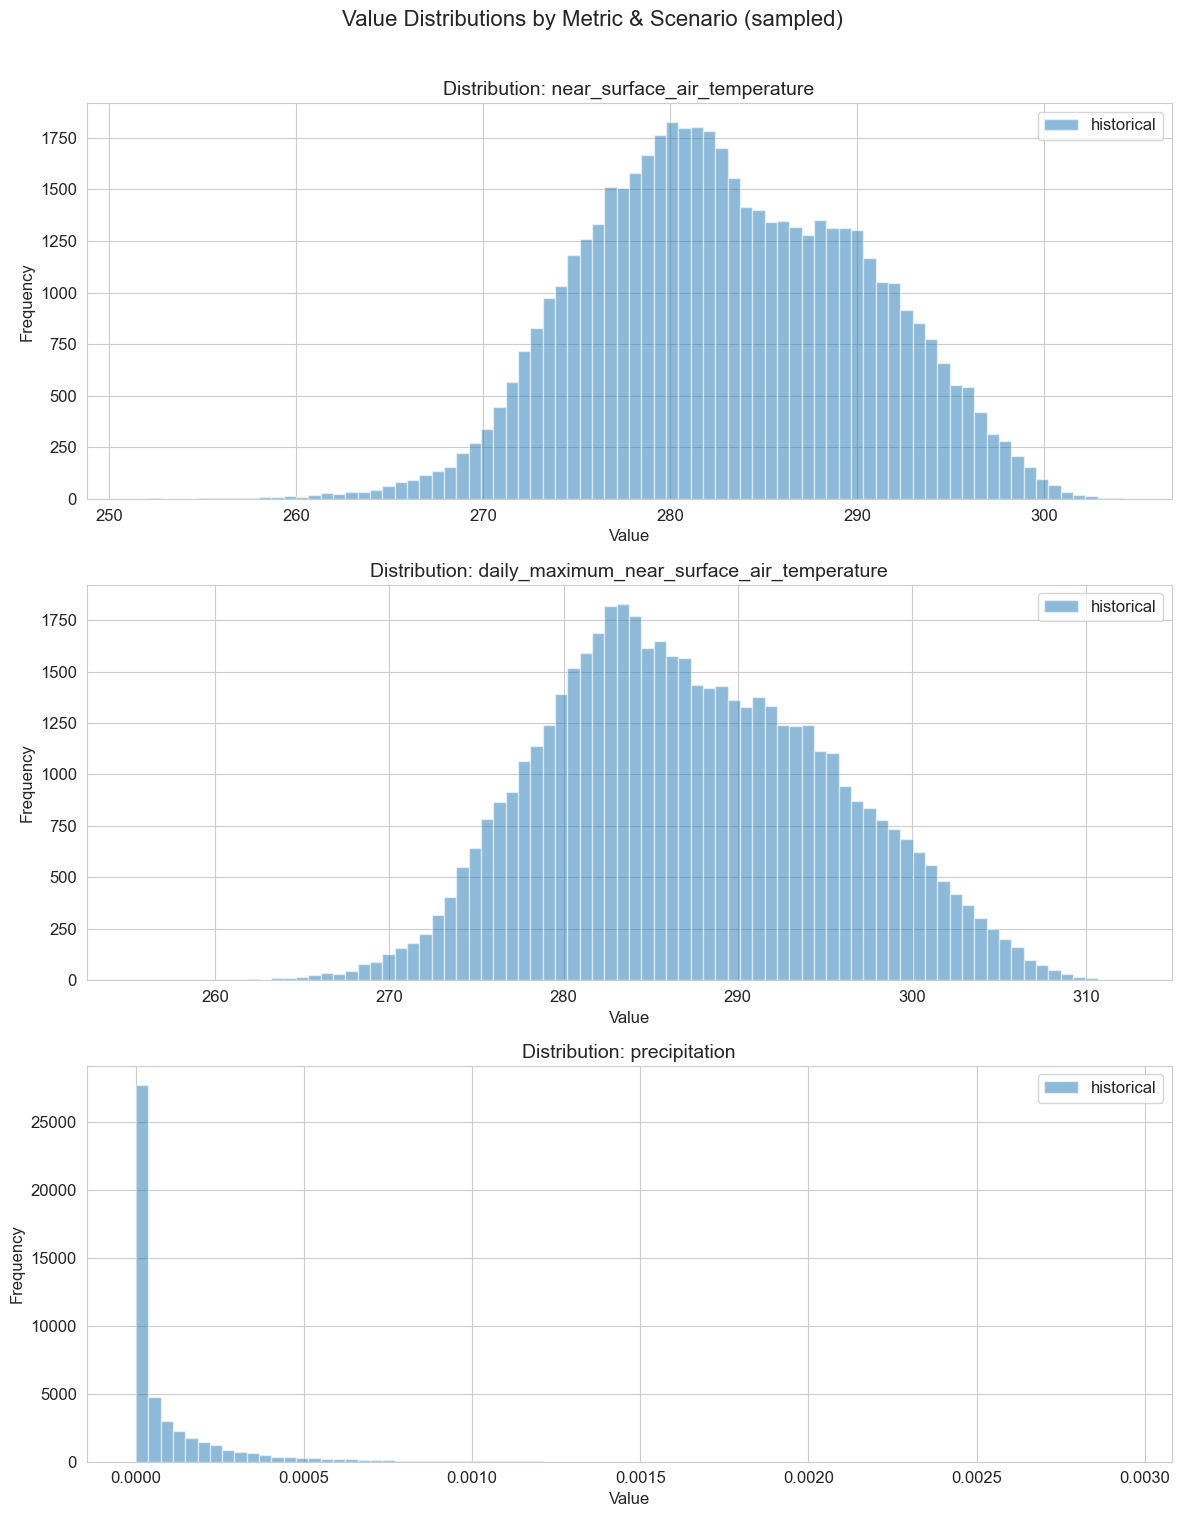

In [12]:
sample_chunks = []
for i in range(min(3, parquet_file.metadata.num_row_groups)):
    chunk = parquet_file.read_row_group(i, columns=['scenario', 'metric', 'value']).to_pandas()
    sample_chunks.append(chunk.sample(min(50000, len(chunk)), random_state=42))

sample_all = pd.concat(sample_chunks, ignore_index=True)
print(f"Sample size for distributions: {len(sample_all):,}")

metric_list = sample_all['metric'].unique()
fig, axes = plt.subplots(len(metric_list), 1, figsize=(12, 5 * len(metric_list)))
if len(metric_list) == 1:
    axes = [axes]

for i, metric_name in enumerate(metric_list):
    subset = sample_all[sample_all['metric'] == metric_name]
    for scenario_name, grp in subset.groupby('scenario'):
        axes[i].hist(grp['value'].dropna(), bins=80, alpha=0.5, label=scenario_name, edgecolor='white')
    axes[i].set_title(f'Distribution: {metric_name}', fontsize=14)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.suptitle('Value Distributions by Metric & Scenario (sampled)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

In [13]:
null_counts = {}

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for col in chunk.columns:
        null_counts[col] = null_counts.get(col, 0) + chunk[col].isnull().sum()
    print(f"Row group {i} done")

null_df = pd.DataFrame([
    {'column': k, 'null_count': v, 'null_pct': round(v / 13_540_116 * 100, 3)}
    for k, v in null_counts.items()
]).sort_values('null_count', ascending=False)

null_df

Row group 0 done
Row group 1 done
Row group 2 done
Row group 3 done
Row group 4 done
Row group 5 done
Row group 6 done
Row group 7 done
Row group 8 done
Row group 9 done
Row group 10 done
Row group 11 done
Row group 12 done


,column,null_count,null_pct
0,scenario,0,0.0
1,nom_dep,0,0.0
2,code_dep,0,0.0
3,time,0,0.0
4,year,0,0.0
5,metric,0,0.0
6,value,0,0.0


In [14]:
pivot = df_yearly.pivot_table(index=['year', 'metric'], columns='scenario', values='mean_value')
print("Scenarios available:", pivot.columns.tolist())
pivot.head(10)

Scenarios available: ['historical', 'ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']


scenario                                         historical  ssp1_2_6  \
year metric                                                             
1982 daily_maximum_near_surface_air_temperature  287.759854       NaN   
     near_surface_air_temperature                283.238685       NaN   
     precipitation                                 0.000083       NaN   
1983 daily_maximum_near_surface_air_temperature  286.477664       NaN   
     near_surface_air_temperature                282.210473       NaN   
     precipitation                                 0.000095       NaN   
1984 daily_maximum_near_surface_air_temperature  286.847960       NaN   
     near_surface_air_temperature                282.464863       NaN   
     precipitation                                 0.000084       NaN   
1985 daily_maximum_near_surface_air_temperature  286.611551       NaN   

scenario                                         ssp2_4_5  ssp5_8_5  
year metric                                                          
1982 daily_maximum_near_surface_air_temperature       NaN       NaN  
     near_surface_air_temperature                     NaN       NaN  
     precipitation                                    NaN       NaN  
1983 daily_maximum_near_surface_air_temperature       NaN       NaN  
     near_surface_air_temperature                     NaN       NaN  
     precipitation                                    NaN       NaN  
1984 daily_maximum_near_surface_air_temperature       NaN       NaN  
     near_surface_air_temperature                     NaN       NaN  
     precipitation                                    NaN       NaN  
1985 daily_maximum_near_surface_air_temperature       NaN       NaN